In [1]:
import json
import re
import subprocess

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import matplotlib.ticker as mticker

from urllib.request import urlopen, HTTPError
from wordcloud import WordCloud, STOPWORDS

In [2]:
def make_wordcloud(df, column_name, ftitle):
    
    text = ' '.join(df[column_name].values)
    
    exclude = [
        'using',
        'CMS',
        'open',
        'data',
        'collider',
        'event',
        'TeV',
        'analysis',
        'based',
        'LHC',
        'particle',
        'end',
        'high',
        'energy',
        'physics',
        'new',
        'experiment'
    ]

    stopwords = set(STOPWORDS)

    for e in exclude:
        stopwords.add(e)
    
    wc = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=600,
        height=400
    ).generate(text)
    
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    #plt.show()

    plt.savefig(f'./figs/{ftitle}.png', dpi=200)

In [3]:
def handle_doi_queries(dois):
    
    doi_url = 'https://doi.org/api/handles/'
    recids = []
        
    for doi in dois:
        '''
        Some of the DOIs referenced are invalid, either having an extra ":" 
        appended to the end or having the year in parentheses appended.
        In the former case they are duplicates and we can skip.
        In the latter clean them up.
        '''
        
        if ':' in doi:
            continue
        if '(' in doi:
            doi = doi[:-6]
            
        try:
            response = json.load(
                urlopen(f'{doi_url}{doi}')
            )
        
            url = response['values'][1]['data']['value']
            recid = url.split('/')[-1]
        
            recids.append(recid)
         
        except HTTPError:
            print('Error '+doi)
        
    return recids
    
def resolve_dois(df):
    '''
    The references that come from the Inspire API results
    often have useful information on the datasets in "misc"
    and often has the CODP records as well. In several cases
    they do not. Since we have the DOIs use the DOI API
    
    https://www.doi.org/the-identifier/resources/factsheets/doi-resolution-documentation
    
    and resolve the CODP record URL and add it to the dataframe.
    
    We can get the information from the DOI using the CODP CLI as well
    (and that's probably better but stay with this for now).
    '''
    df['codp_recids'] = df['dois_referenced'].map(
        lambda x: handle_doi_queries(x)
    )

In [4]:
def process_dataframe(input_json):
    
    exclude_names = [
        'McCauley',
        'Bellis',
        'Lange',
        'Tibor',
        'Šimko',
        'Carerra',
        'Geiser',
        'Lassila-Perini',
        'Dallmeier-Tiessen',
        'Calderon',
        'Rao',
        'Socher',
        'Herterich'
    ]
    
    df = pd.read_json(input_json)
    
    '''
    Adds a new column where each row is a list of names from exclude_names 
    that match (substring) those in the author list contained in the authors column
    '''
    df['exclude'] = df['authors'].map(lambda x: [e for e in exclude_names if any(e in xn for xn in x)])
    
    print(df.shape[0])
    
    '''
    Filter out rows in-place where there are matches from the
    excluded names
    '''
    df = df[df['exclude'].str.len() == 0]
    
    print(df.shape[0])
    
    '''
    Reorder the rows by date and reorder the indices. 
    Then add an index column.
    '''
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop='True', inplace=True)
    df.reset_index(inplace=True)
    
    '''
    Format date
    '''
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    
    return df

In [5]:
def make_histogram(df, date_range, nbins, title, ftitle):
    
    dates = df['date'].to_numpy(dtype='datetime64[Y]')
    
    h, b = np.histogram(
        dates.astype(int),
        range=date_range,
        bins=nbins
    )

    b = np.array([np.datetime64(int(value), 'Y') for value in b])

    plt.bar(b[:-1], h, width=np.diff(b), ec='black', align='edge')
    plt.gca().set_xticks(b)
    plt.gca().set_xticklabels(b, rotation=45)

    plt.title(title)

    plt.tight_layout()
    plt.savefig(f'./figs/{ftitle}.png', dpi=200)

In [6]:
data_releases = [
    '2014-11-20',
    '2016-04-22',
    '2017-12-20',
    '2019-07-18',
    '2020-08-27',
    '2020-12-21',
    '2021-12-20',
    '2022-12-05',
    '2023-09-18',
    '2024-04-02'
]

These papers reference a CMS open data DOI

In [7]:
idf = process_dataframe('data/inspire.json')

114
89


In [8]:
resolve_dois(idf)

Error 10.7483/OPENDATA.CMS.7347
Error 10.7483/OPENDATA.CMS.29BN
Error 10.7483/OPENDATA.CMS.UZD7


In [9]:
date_generated = dt.datetime.today().strftime('%Y-%m-%d')
print(
    date_generated
)

2025-12-08


In [10]:
idf.head()

,index,abstract,authors,citations,date,document_type,doi,dois_referenced,keywords,publication,title,url,exclude,codp_recids
0,0,The splitting function is a universal property...,"[Larkoski, Andrew, Marzani, Simone, Thaler, Je...",73,2017-04-19,article,10.1103/PhysRevLett.119.132003,"[10.7483/OPENDATA.CMS.3S7F.2E9W, 10.7483/OPEND...","[jet: energy, energy: high, singularity: colli...",Phys.Rev.Lett.,Exposing the QCD Splitting Function with CMS O...,https://inspirehep.net/literature/1591972,[],"[5, 21]"
1,1,The application of deep learning techniques us...,"[Madrazo, Celia Fernández, Cacha, Ignacio Here...",20,2017-08-25,conference paper,10.1051/epjconf/201921406017,"[10.7483/opendata.cms.txt4.4rrp, 10.7483/opend...","[Deep Learning, Machine Learning, Convolutiona...",EPJ Web Conf.,Application of a Convolutional Neural Network ...,https://inspirehep.net/literature/1618344,[],"[1395, 1633, 1544]"
2,2,Daily operation of a large-scale experiment is...,"[Borisyak, Maxim, Ratnikov, Fedor, Derkach, De...",15,2017-09-26,conference paper,10.1088/1742-6596/898/9/092041,"[10.7483/OPENDATA.CMS.6BPY.XFRQ:, 10.7483/OPEN...","[data acquisition, quality: monitoring, CMS, C...",J.Phys.Conf.Ser.,Towards automation of data quality system for ...,https://inspirehep.net/literature/1625297,[],"[8, 14, 12]"
3,3,The need for processing the ever-increasing am...,"[Piparo, D., Tejedor, E., Guiraud, E., Ganis, ...",3,2017-11-27,conference paper,10.1088/1742-6596/898/7/072022,[10.7483/OPENDATA.CMS.JCDC.9CUH],[],J.Phys.Conf.Ser.,Expressing Parallelism with ROOT,https://inspirehep.net/literature/1638554,[],[1640]
4,4,Deep generative models parametrised by neural ...,"[Musella, Pasquale, Pandolfi, Francesco]",102,2018-05-03,article,10.1007/s41781-018-0015-y,"[10.7483/OPENDATA.CMS.Q3BX.69VQ, 10.7483/OPEND...","[Generative adversarial networks, Deep learnin...",Comput.Softw.Big Sci.,Fast and Accurate Simulation of Particle Detec...,https://inspirehep.net/literature/1671151,[],"[1539, 1555, 1562, 1348, 1369, 1469, 1553, 155..."


In [11]:
idf.tail()

,index,abstract,authors,citations,date,document_type,doi,dois_referenced,keywords,publication,title,url,exclude,codp_recids
84,84,Vector-like quark partners appear in many BSM ...,"[Ghosh, Anupam, Ghosh, Soumyadip, Mitra, Soure...",2,2025-07-08,article,,"[10.7483/OPENDATA.CMS.1BNU.8V1W, 10.7483/OPEND...",[],,Improving Sensitivity of Vector-like Top Partn...,https://inspirehep.net/literature/2942757,[],"[415, 19949, 19933, 19940, 19941, 19942, 19943..."
85,85,Physics beyond the Standard Model (SM) must ex...,"[Mastandrea, Radha Rose]",0,2025-08-18,thesis,,[10.7483/OPENDATA.CMS.UZD7],[],,Casting a Wide (Neural) Net: Using Machine Lea...,https://inspirehep.net/literature/2961202,[],[]
86,86,<p>This thesis presents two novel methodologie...,"[Bal, Aritra]",0,2025-09-18,thesis,,"[10.7483/OPENDATA.CMS.1KTG.X0W4, 10.7483/OPEND...","[machine learning, quantum machine learning, a...",,Classical and Quantum Machine Learning for Ano...,https://inspirehep.net/literature/2970847,[],"[30508, 30541]"
87,87,"The rise of foundation models -- large, pretra...","[Hallin, Anna]",4,2025-09-29,conference paper,,"[10.7483/OPENDATA.CMS.1KTG.X0W4, 10.7483/OPEND...",[],,Foundation models for high-energy physics,https://inspirehep.net/literature/2973870,[],"[30508, 30541]"
88,88,The petabyte-scale data generated annually by ...,"[Gupta, Akshat, Doglioni, Caterina, Elliott, T...",0,2025-11-17,article,,"[10.7483/OPENDATA.CMS.KL8H.HFVH, 10.7483/OPEND...",[],,BOA Constrictor: A Mamba-based lossless compre...,https://inspirehep.net/literature/3083484,[],"[6010, 6010]"


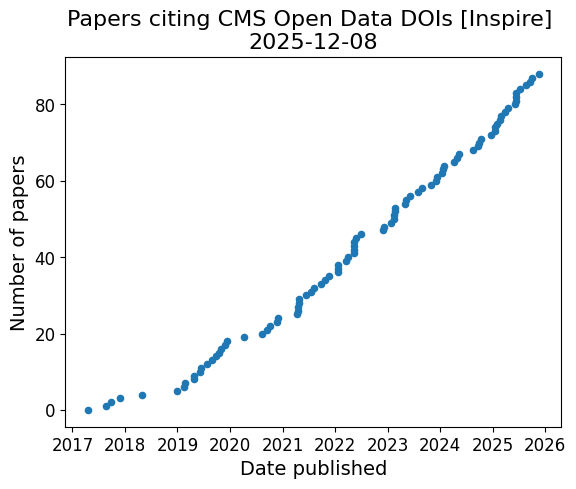

In [12]:
def add_release_dates(ax):
    
    ax.set_xlim([dt.date(2014, 1, 1), dt.date(2026, 1, 1)])

    for dr in data_releases:
    
        date = dt.datetime.strptime(dr, '%Y-%m-%d').date()

        ax.annotate(
            "",
            xy=(date, -3), 
            xytext=(date, -2),        
            arrowprops=dict(facecolor='black', shrink=0.01),
        )


ax = idf.plot(
    kind='scatter',
    x='date', 
    y='index',
    #title=f'Papers citing CMS Open Data DOIs [Inspire] \n{date_generated}'
)

ax.set_xlabel('Date published', fontsize=14)
ax.set_ylabel('Number of papers', fontsize=14)
ax.set_title(f'Papers citing CMS Open Data DOIs [Inspire] \n{date_generated}', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#add_release_dates(ax)
plt.savefig('./figs/inspire-npapers.png', dpi=200)

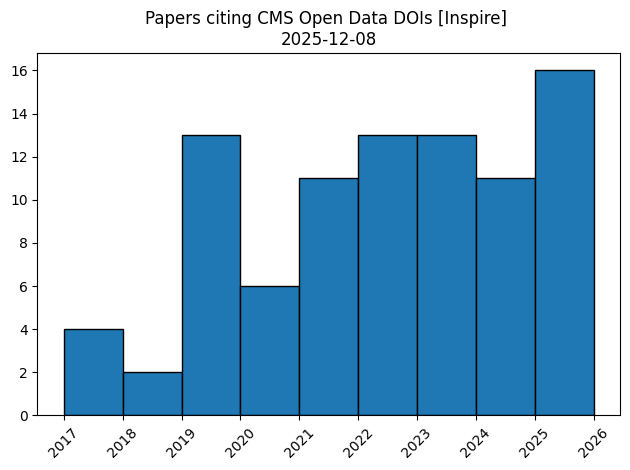

In [13]:
make_histogram(
    idf,
    (np.datetime64('2017').astype(int), np.datetime64('2026').astype(int)),
    9,
    f'Papers citing CMS Open Data DOIs [Inspire] \n{date_generated}',
    'inspire-npapers-hist'
)

In [14]:
nzero = len(idf[idf['citations'] == 0])

nzdf = idf[idf['citations'] > 0]

print(f'{nzero} papers with 0 citations')
print(f'{len(nzdf)} papers with > 0 citations')

21 papers with 0 citations
68 papers with > 0 citations


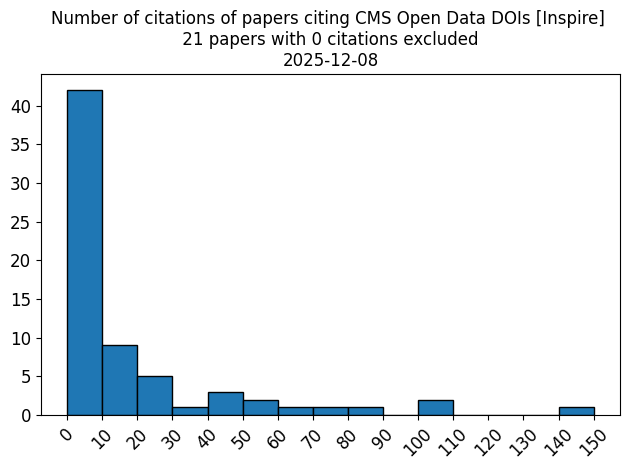

In [15]:
h, b = np.histogram(
    nzdf['citations'],
    range=(0,150),
    bins=15
)

plt.bar(b[:-1], h, width=np.diff(b), ec='black', align='edge')

plt.gca().set_xticks(b)
plt.xticks(fontsize=12)
plt.gca().set_xticklabels(b.astype(int), rotation=45)
plt.yticks(fontsize=12)

#plt.gca().set_yscale('log')
plt.title(
    f'Number of citations of papers citing CMS Open Data DOIs [Inspire] \n {nzero} papers with 0 citations excluded \n{date_generated}'
)

plt.tight_layout()

plt.savefig('./figs/inspire-citations.png', dpi=200)

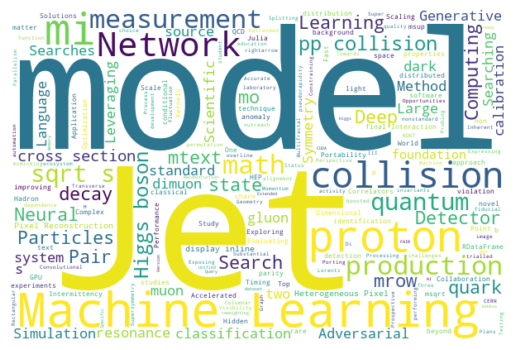

In [16]:
make_wordcloud(idf, 'title', 'inspire-wc-title')

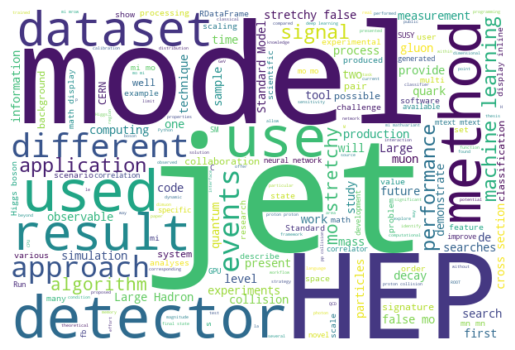

In [17]:
make_wordcloud(idf, 'abstract', 'inspire-wc-abstract')

In [18]:
def get_codp_title(recid):
    
    results = subprocess.run([
        'cernopendata-client',
        'get-metadata',
        '--recid',
        recid,
        '--output-value',
        'title'],
        stdout=subprocess.PIPE
    )
    
    return results.stdout.decode('utf-8')

In [19]:
def get_codp_categories(recid):

    results = subprocess.run([
        'cernopendata-client',
        'get-metadata',
        '--recid',
        recid,
        '--output-value',
        'categories'],
        stdout=subprocess.PIPE
    )

    results = results.stdout.decode('utf-8')

    if 'ERROR' in results:
        return '', []
    
    categories = json.loads(results)
    
    return categories['primary'], categories['secondary']

In [20]:
titles = idf['codp_recids'].map(lambda x: [get_codp_title(str(rid)) for rid in x])

In [21]:
categories = idf['codp_recids'].map(lambda x: [get_codp_categories(str(rid)) for rid in x])

In [22]:
# Make this more pythonic

primary_categories = []
secondary_categories = []

for c in categories:

    if len(c) > 0:

        for d in c:

            if d[0]:
                primary_categories.append(d[0])
            if d[1]:
                for e in d[1]:
                    secondary_categories.append(e)

print(primary_categories)
print(secondary_categories)

['Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard M

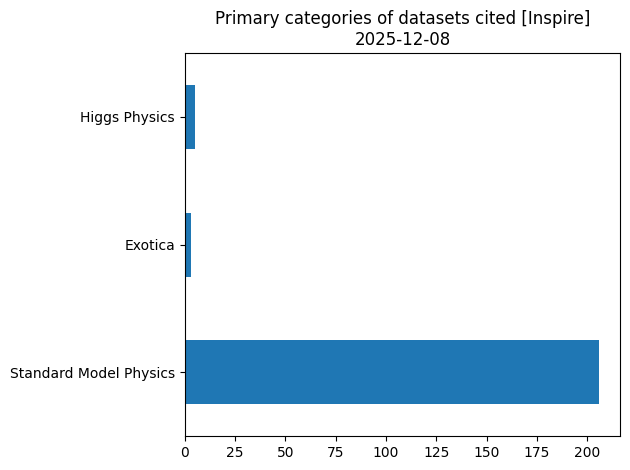

In [23]:
pd.Series(primary_categories).value_counts(sort=False).plot(
    kind='barh',
    title=f'Primary categories of datasets cited [Inspire]\n{date_generated}',
    #figsize=(12,20)
)

plt.tight_layout()
plt.savefig('./figs/inspire-dataset-primary-categories.png', dpi=200)

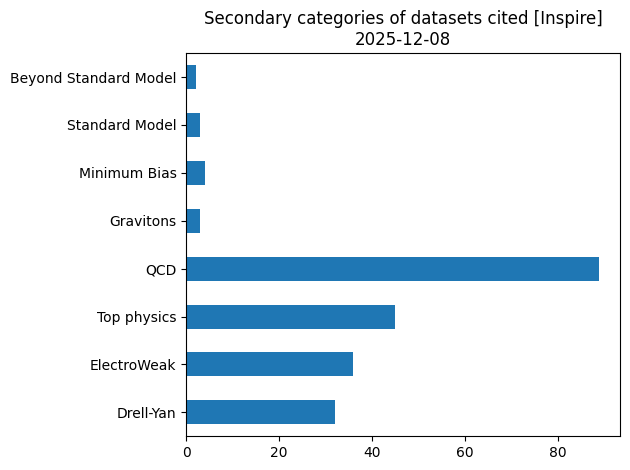

In [24]:
pd.Series(secondary_categories).value_counts(sort=False).plot(
    kind='barh',
    title=f'Secondary categories of datasets cited [Inspire]\n{date_generated}',
    #figsize=(12,20)
)

plt.tight_layout()
plt.savefig('./figs/inspire-dataset-secondary-categories.png', dpi=200)

In [25]:
titles = [[t.rstrip() for t in title] for title in titles]

In [26]:
'''
Fetch out the dataset names by searching for /A/B/C pattern.

Useful information:
- A
- Run201XY from B
- C
'''

dataset_names = []
dataset_eras = []
dataset_tiers = []

others = []

for title in titles:
    for t in title:
        
        if len(re.findall('/', t)) == 3:
            
            t = t.split('/')
            
            if 'Run201' in t[2]:
                dataset_eras.append(t[2].split('-')[0])
                
            dataset_names.append(t[1])
            dataset_tiers.append(t[3])
            
        else:
            others.append(t)
    

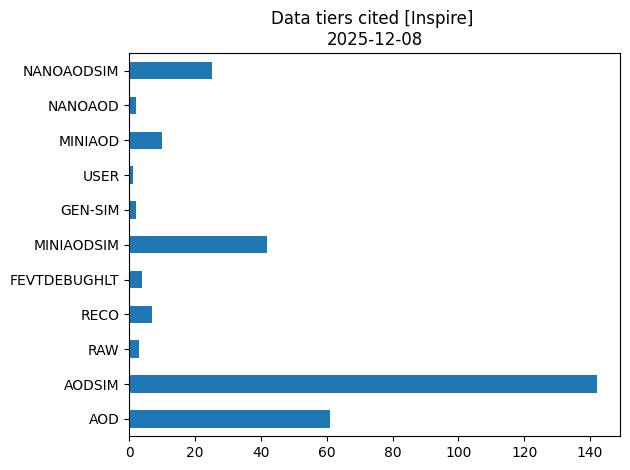

In [27]:
pd.Series(dataset_tiers).value_counts(sort=False).plot(
    kind='barh',
    title=f'Data tiers cited [Inspire] \n{date_generated}'
)

plt.tight_layout()
plt.savefig('./figs/inspire-datatiers.png', dpi=200)

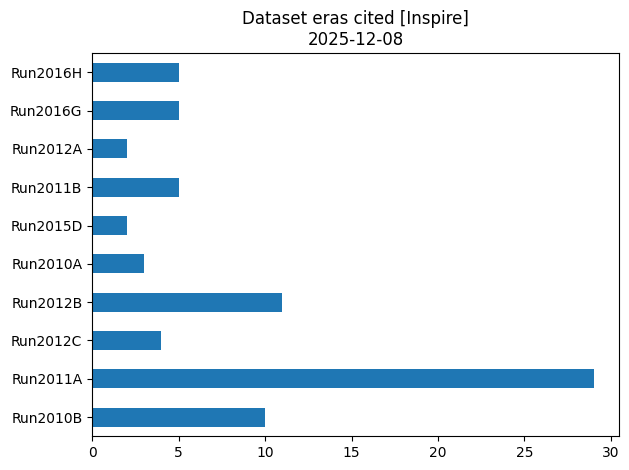

In [28]:
pd.Series(dataset_eras).value_counts(sort=False).plot(
    kind='barh',
    title=f'Dataset eras cited [Inspire]\n{date_generated}'
)

plt.tight_layout()
plt.savefig('./figs/inspire-dataset-eras.png', dpi=200)

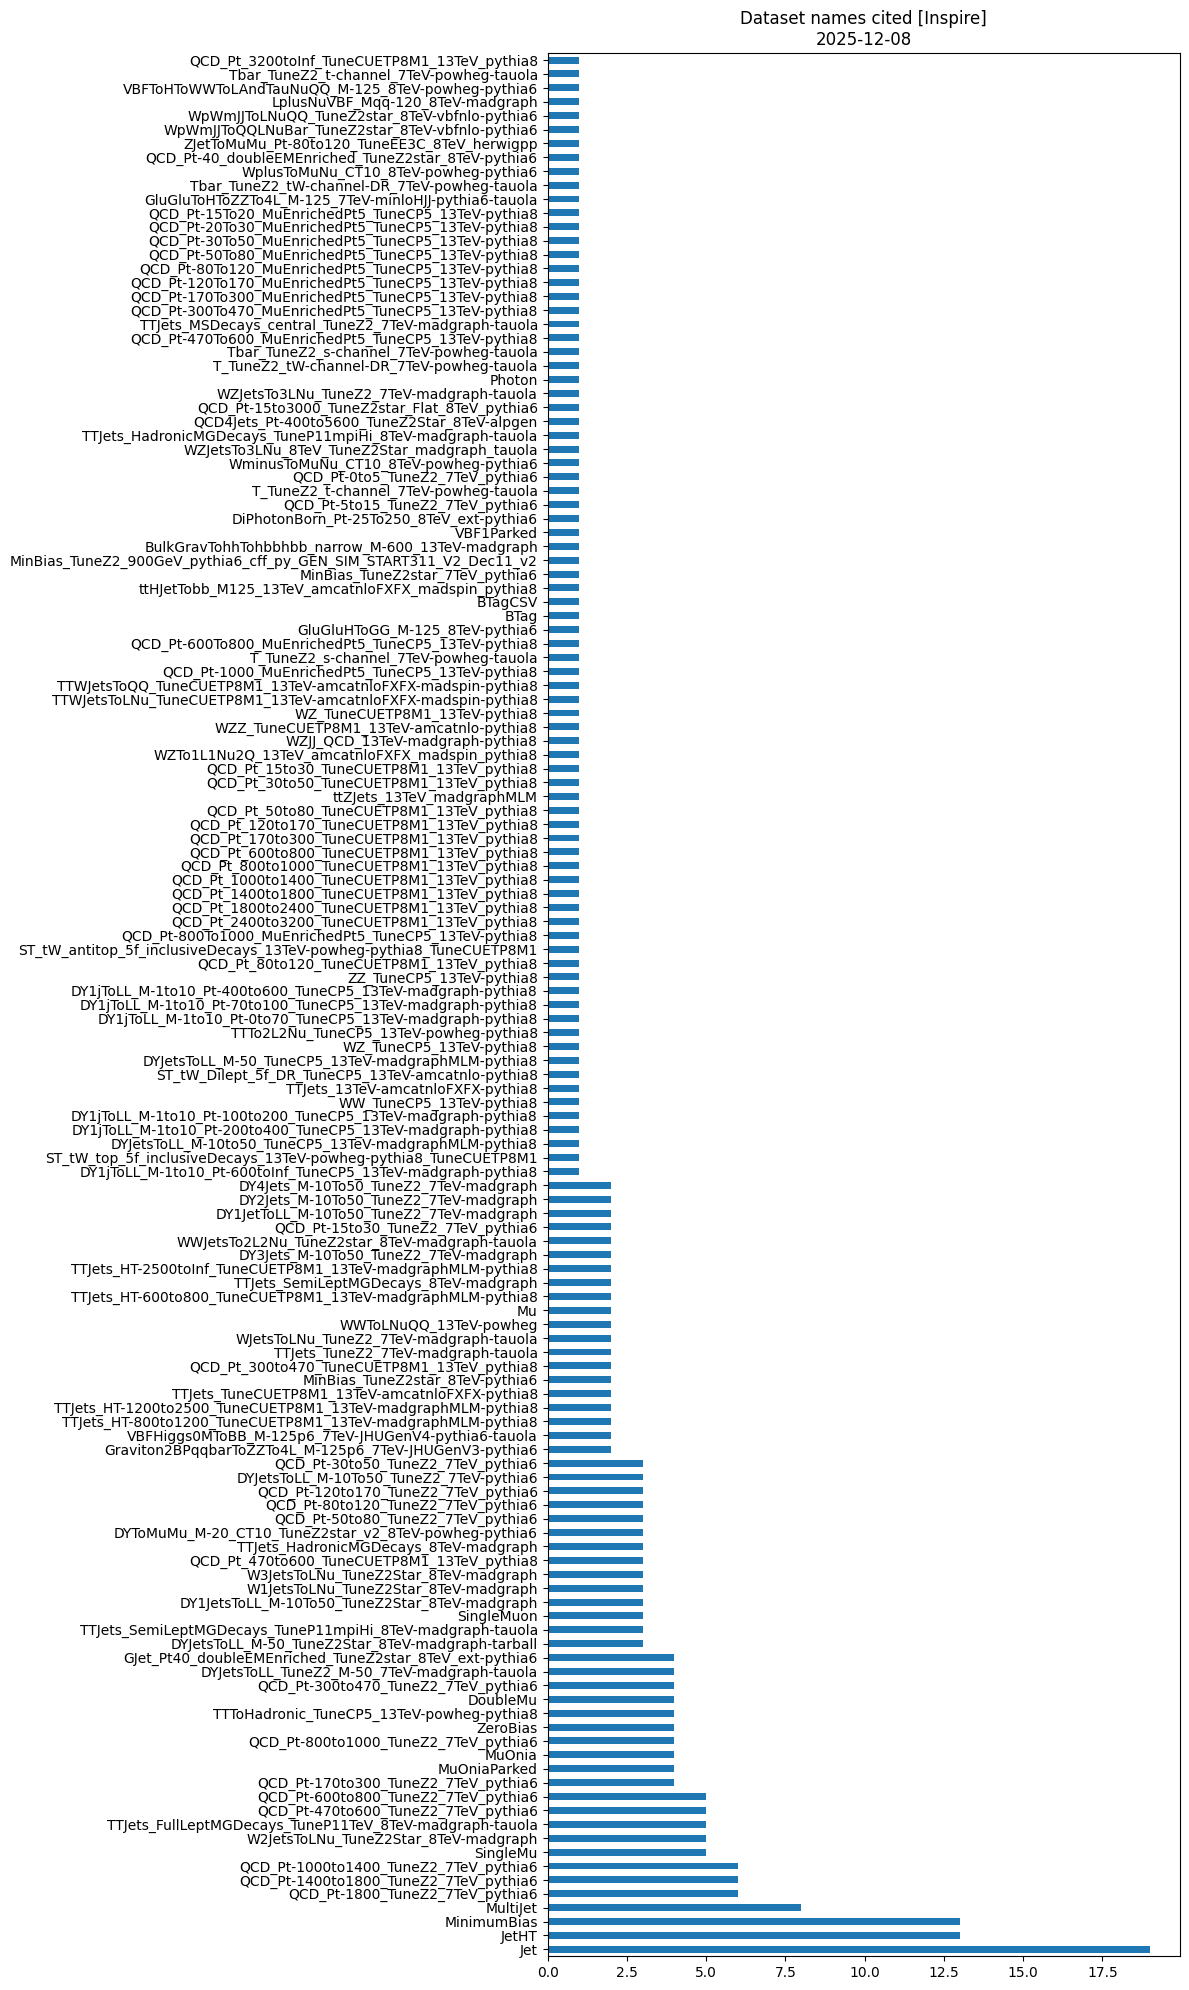

In [29]:
pd.Series(dataset_names).value_counts(sort=True).plot(
    kind='barh',
    title=f'Dataset names cited [Inspire]\n{date_generated}',
    figsize=(12,20)
)

plt.tight_layout()
plt.savefig('./figs/inspire-dataset-names.png', dpi=200)

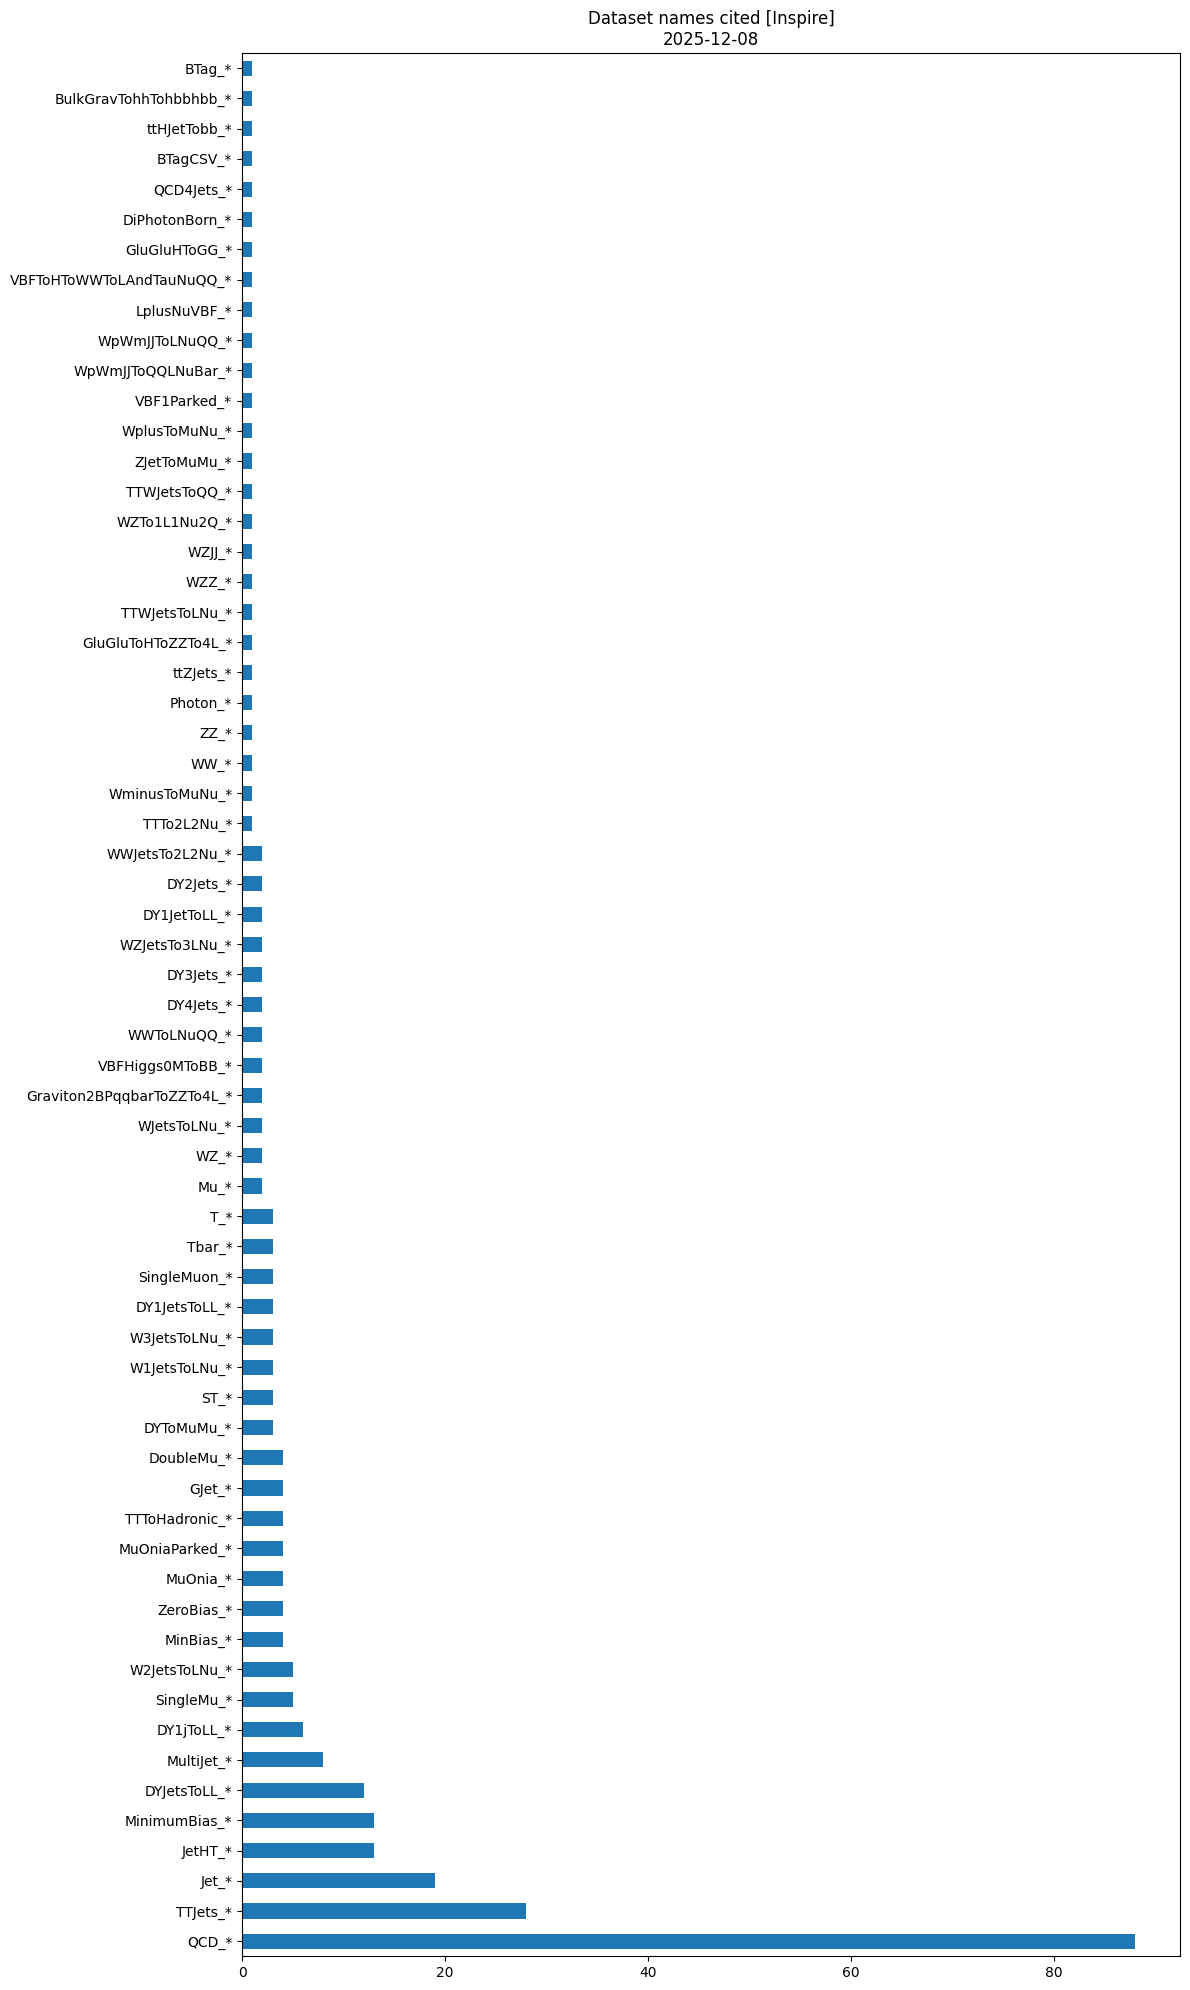

In [30]:
dsn = pd.Series(dataset_names)

groups = dsn.str.split("_").str[0] + "_*"

groups.value_counts(sort=True).plot(
    kind='barh',
    title=f'Dataset names cited [Inspire]\n{date_generated}',
    figsize=(12,20)
)

plt.tight_layout()
plt.savefig('./figs/inspire-dataset-names-groups.png', dpi=200)

In [31]:
publications = idf['publication'].values
publications = [p for p in publications if p]

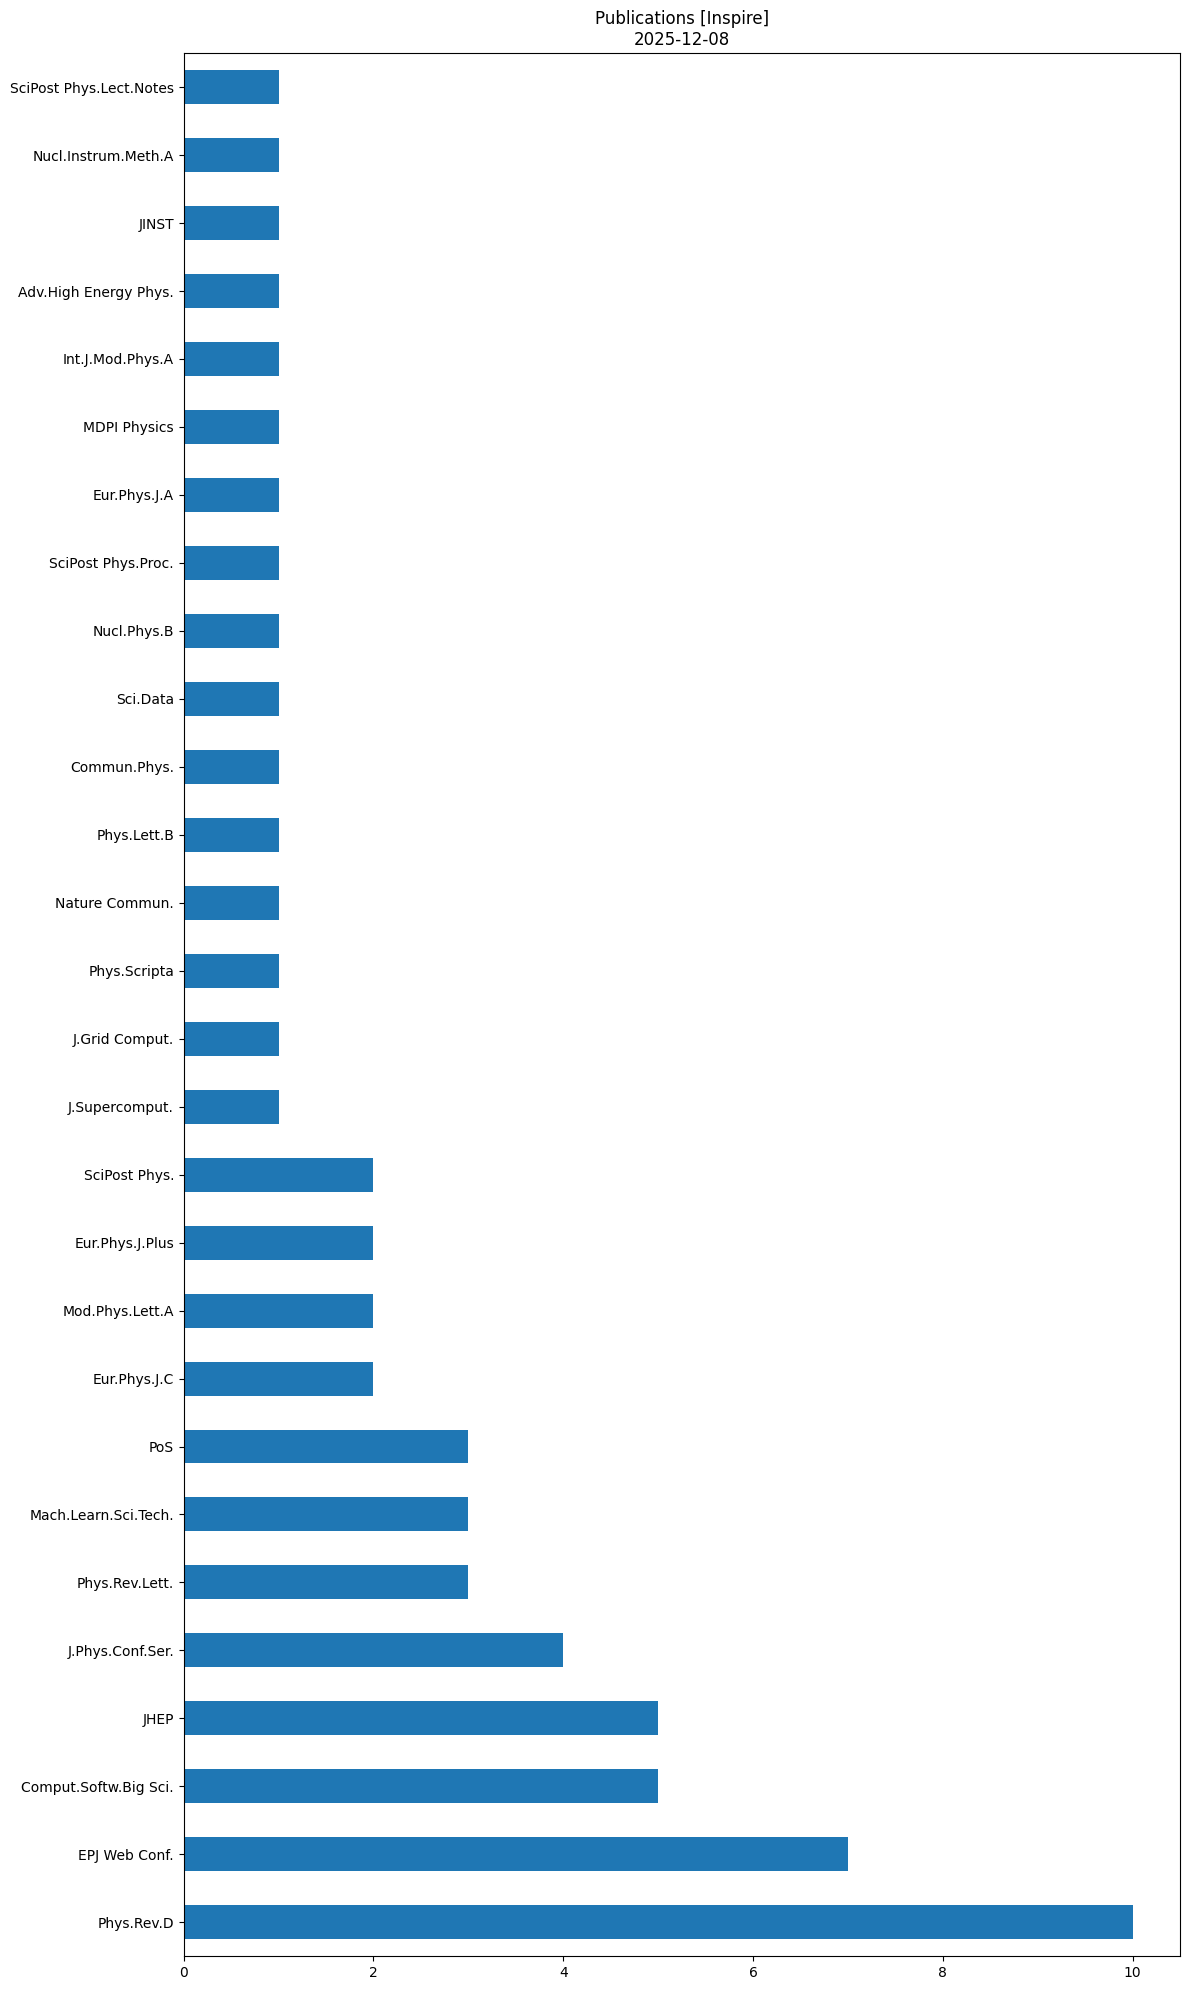

In [32]:
pd.Series(publications).value_counts(sort=True).plot(
    kind='barh',
    title=f'Publications [Inspire]\n{date_generated}',
    figsize=(12,20)
)

plt.tight_layout()
plt.savefig('./figs/inspire-publications.png', dpi=200)

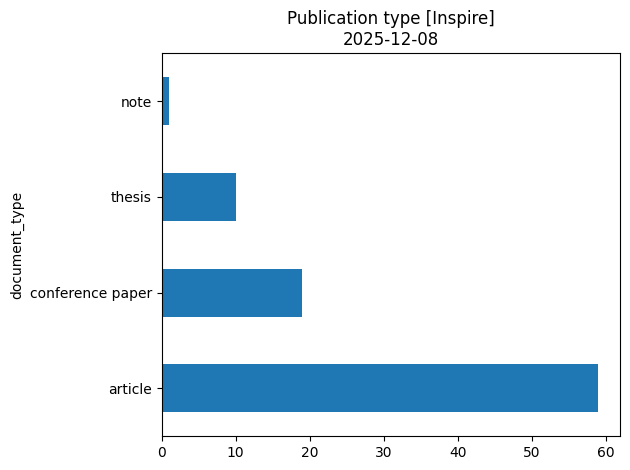

In [33]:
idf['document_type'].value_counts(sort=False).plot(
    kind='barh',
    title=f'Publication type [Inspire]\n{date_generated}'
)

plt.tight_layout()
plt.savefig('./figs/inspire-publication-type.png', dpi=200)

In [34]:
adf = process_dataframe('data/arxiv.json')

100
98


In [35]:
adf.head()

,index,abstract,authors,date,doi,title,url,exclude
0,0,"We model the radio, optical, and X-ray emissio...","[A. Panaitescu, P. Kumar]",2000-10-12,https://arxiv.org/abs/astro-ph/0010257v2,Physical Parameters for the Afterglows of GRB ...,https://arxiv.org/abs/astro-ph/0010257v2,[]
1,1,A CCD photometric study of the dense galactic ...,"[L. L. Kiss, Gy. Szabo, K. Sziladi, G. Furesz,...",2001-07-08,https://arxiv.org/abs/astro-ph/0107144v1,A variable star survey of the open cluster M37,https://arxiv.org/abs/astro-ph/0107144v1,[]
2,2,We present the $UBVRI$ CCD photometry in the r...,"[R. K. S. Yadav, Ram Sagar]",2004-03-09,https://arxiv.org/abs/astro-ph/0403205v1,A comprehensive CCD photometric study of the o...,https://arxiv.org/abs/astro-ph/0403205v1,[]
3,3,In this paper we study the evolution of core a...,"[S. Sharma, A. K. Pandey, K. Ogura, H. Mito, K...",2006-07-24,https://arxiv.org/abs/astro-ph/0607538v1,Wide Field CCD photometry around nine open clu...,https://arxiv.org/abs/astro-ph/0607538v1,[]
4,4,Using homogeneous CCD photometric data from th...,"[Saurabh Sharma, A. K. Pandey, K. Ogura, T. Ao...",2008-03-02,https://arxiv.org/abs/0803.0122v1,Mass functions and photometric binaries in nin...,https://arxiv.org/abs/0803.0122v1,[]


In [36]:
adf.tail()

,index,abstract,authors,date,doi,title,url,exclude
93,93,Current open-source training pipelines for Chi...,"[Wei Huang, Anda Cheng, Zhao Zhang, Yinggui Wang]",2025-09-01,https://arxiv.org/abs/2509.01354v1,DPF-CM: A Data Processing Framework with Priva...,https://arxiv.org/abs/2509.01354v1,[]
94,94,Accurate International Classification of Disea...,"[Hong-Jie Dai, Zheng-Hao Li, An-Tai Lu, Bo-Tsz...",2025-09-23,https://arxiv.org/abs/2509.18846v1,Model selection meets clinical semantics: Opti...,https://arxiv.org/abs/2509.18846v1,[]
95,95,The CICADA (Calorimeter Image Convolutional An...,"[Lino Gerlach, Elliott Kauffman, Abhishikth Ma...",2025-10-17,https://arxiv.org/abs/2510.15672v2,Evaluation of Novel Fast Machine Learning Algo...,https://arxiv.org/abs/2510.15672v2,[]
96,96,Power system time series analytics is critical...,"[Zhenghao Zhou, Yiyan Li, Xinjie Yu, Runlong L...",2025-11-11,https://arxiv.org/abs/2511.07777v1,A Causal-Guided Multimodal Large Language Mode...,https://arxiv.org/abs/2511.07777v1,[]
97,97,We present a search for the pair production of...,[CMS Collaboration],2025-11-20,https://arxiv.org/abs/2511.16394v2,Search for Higgsinos in final states with low-...,https://arxiv.org/abs/2511.16394v2,[]


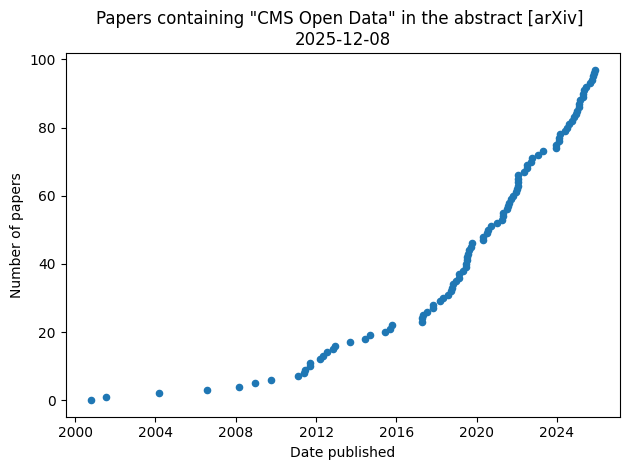

In [37]:
def add_release_dates(ax):
    
    ax.set_xlim([dt.date(2014, 1, 1), dt.date(2024, 12, 31)])

    for dr in data_releases:
    
        date = dt.datetime.strptime(dr, '%Y-%m-%d').date()

        ax.annotate(
            "",
            xy=(date, -1.2), 
            xytext=(date, 0),        
            arrowprops=dict(facecolor='black', shrink=0.01),
        )

ax = adf.plot(
    kind='scatter',
    x='date', 
    y='index',
    title=f'Papers containing "CMS Open Data" in the abstract [arXiv] \n{date_generated}'
)

ax.set_xlabel('Date published')
ax.set_ylabel('Number of papers')

#add_release_dates(ax)

plt.tight_layout()
plt.savefig('./figs/arxiv-npapers.png', dpi=200)

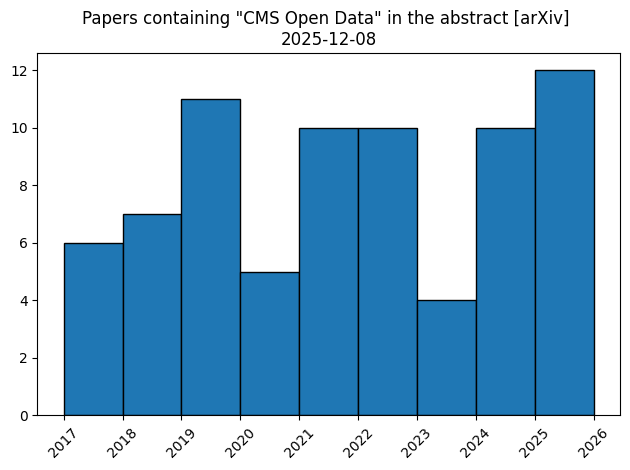

In [38]:
make_histogram(
    adf,
    (np.datetime64('2017').astype(int), np.datetime64('2026').astype(int)),
    9,
    f'Papers containing "CMS Open Data" in the abstract [arXiv] \n{date_generated}',
    'arxiv-npapers-hist'
)

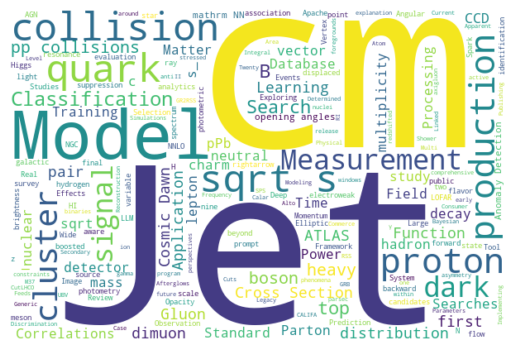

In [39]:
make_wordcloud(adf, 'title', 'arxiv-wc-title')

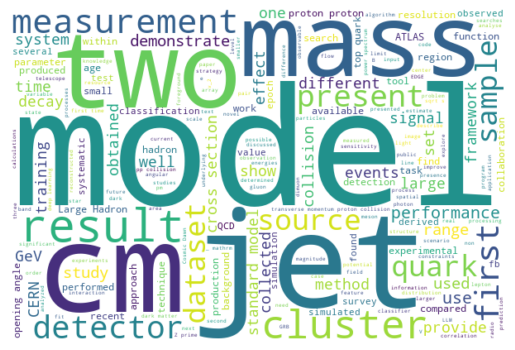

In [40]:
make_wordcloud(adf, 'abstract', 'arxiv-wc-abstract')